In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
db = pd.read_parquet('db_P4.parquet.gzip')
db = db.drop(columns='log_SiteEnergyUseWN(kBtu)') # On supprime la cible 2 pour éviter toute confusion
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
db.columns

Index(['OSEBuildingID', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'per_gfa_parking',
       'per_gfa_bulding', 'site_per_electricity', 'site_per_steam',
       'site_per_gaz', 'log_TotalGHGEmissions', 'Bank Branch',
       'College/University', 'Data Center', 'Distribution Center',
       'Fitness Center/Health Club/Gym', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
       'Laboratory', 'Manufacturing/Industrial Plant', 'Medical Office',
       'Multifamily Housing', 'Non-Refrigerated Warehouse', 'Office', 'Other',
       'Other - Entertainment/Public Assembly', 'Other - Recreation',
       'Other - Services', 'Parking', 'Pre-school/Daycare',
       'Refrigerated Warehouse',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Restaurant',
       'Retail Store', 'Self-Storage Facility', 'Social/Meeting Hall',
       'Supermarket/Grocery Store', 'Swimming Pool', 'Worship Facility'],
      dtype='o

Ce qu'il reste à faire 


- Faire un KFold avec 5 splits, et en fixant random_state

- faire des modèles : linearRegression randomforest, xgboost, lightgbm, pourquoi pas un autre ? réseau de neurone ou SVM


- faire une première validation croisée sans chercher à optimiser les hyperparamètres

- faire une validation croisée avec les meilleurs hyperparamètres

- comparer les modèles selon le r2, rmse

# Variables prédictives X & Cible y 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [5]:
X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID']).copy()
X = np.array(X)
X

array([[  47.6122 , -122.33799, 1927.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.61317, -122.33393, 1996.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.61393, -122.3381 , 1969.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [  47.63644, -122.35784, 1974.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.52832, -122.32431, 1989.     , ...,    0.     ,    0.     ,
           0.     ],
       [  47.53939, -122.29536, 1938.     , ...,    0.     ,    0.     ,
           0.     ]])

In [6]:
y = db['log_TotalGHGEmissions'].copy()
y = np.array(y)
y

array([5.52138091, 5.68988637, 7.64457479, ..., 5.40959037, 3.09602999,
       3.72013584])

# Train & Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2023)

# Modèle 

In [8]:
reg = LinearRegression(normalize=True).fit(X_train, y_train) # Régression linéaire

In [9]:
reg.score(X, y) # R2

0.5750602724288996

In [10]:
y_pred = reg.predict(X_test) # Prédiction sur X_test

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.31579486e+00  2.23609250e+00  5.91228645e-03  1.48974171e-01
  6.44612765e-02  8.67044767e+11  8.67044767e+11  3.88894610e-01
  5.43199853e+00  3.52772188e+00 -7.10665887e-01  7.23385384e-01
  9.19990831e+00 -4.75504806e-01 -2.74439409e-01 -1.43244215e+00
  2.01828558e+00  5.19198512e-01  1.77812471e-02  2.16122518e+00
  1.77878717e-02  8.40732458e-01 -1.52298873e-01 -4.09696886e-01
  3.37760761e-01  5.55000719e-01  2.89683152e-01  5.94926782e-01
  8.63016653e-01  5.89923403e-01 -3.89628244e-01  5.28284695e-01
 -1.68379239e-01  9.14960930e-01  5.04896727e-01 -1.06114355e+00
 -3.02643758e-01  1.72592097e+00  0.00000000e+00 -1.02657475e+00]
Mean squared error: 1.13
Coefficient of determination: 0.47


# Cross validation

In [13]:
cross_val_score(LinearRegression(),X_train,y_train,cv=5)#,scoring='r2')

array([0.3321599 , 0.46996187, 0.51859796, 0.52340984, 0.52167304])

In [14]:
from sklearn.model_selection import KFold

In [15]:
# Create 5 folds
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create a model 
model = LinearRegression()

# Train and evaluate multiple models using kfolds
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print("Mean:", results.mean())
print("Std:", results.std())

[0.54784005 0.58280695 0.49225154 0.01848659 0.56321598]
Mean: 0.44092022172627504
Std: 0.21335652240578026


In [16]:
########################

In [17]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(LinearRegression().fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

1.0220306136287505 0.28837970443069705


In [18]:
pred = LinearRegression().fit(X_train,y_train).predict(X_test)
print(
    mean_squared_error(pred,y_test),
    r2_score(pred,y_test))

1.1326884159450255 0.3052028726338353


# RF 

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

list_pred = []
list_val = []

for train, test in kfold:
    list_pred.append(RandomForestRegressor().fit(X_train[train],y_train[train]).predict(X_train[test]))
    list_val.append(y_train[test])
    
list_pred = np.concatenate(list_pred)
list_val = np.concatenate(list_val)

print(
    mean_squared_error(list_pred,list_val),
    r2_score(list_pred,list_val))

0.771434758904655 0.4345799993753423


In [21]:
import seaborn as sns


<AxesSubplot:>

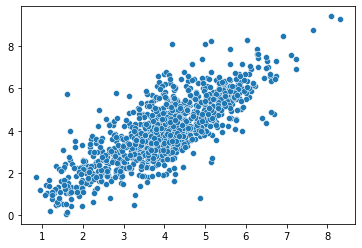

In [22]:
sns.scatterplot(x=list_pred,y=list_val)